## References Used:
[1] NPTEL IIT Guwahati, “Lec 49: Diffusion maps,” YouTube, Mar. 31, 2022. https://www.youtube.com/watch?v=SaqJ8x4vQ6U (accessed Mar. 25, 2025).

[2] Wikipedia Contributors, “Diffusion map,” Wikipedia, Jan. 03, 2025.
‌

[3] Coifman, R.R.; Lafon, S; Lee, A B; Maggioni, M; Nadler, B; Warner, F; Zucker, S W (2005). 

## Load the dataset

In [1]:
import pandas as pd
import numpy as np

def load_dataset():
    base_path = 'UCI-HAR Dataset/train/Inertial Signals/'
    signals = [
        'body_acc_x', 'body_acc_y', 'body_acc_z',
        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
        'total_acc_x', 'total_acc_y', 'total_acc_z'
    ]

    data = [pd.read_csv(f"{base_path}{signal}_train.txt", sep=r"\s+", header=None) for signal in signals]

    x = np.stack(data, axis=1)
    print(x.shape)
    return x

X_train = load_dataset()

(7352, 9, 128)


In [2]:
y_train = pd.read_csv('UCI-HAR Dataset/train/y_train.txt', header=None)
y_train = y_train.values.ravel()

In [3]:
y_train.shape

(7352,)

## Pairwise distance matrix(similarity matrix)

Dimensionality reduction using Diffusion maps is done based on the algorithm suggested in 
[1]

In [4]:
# Eucledean Pairwise distance matrix
pairwise_eucleadean_dissimilarity_matrix = np.zeros((1000, 1000))
for i in range(X_train[:1000].shape[0]):
    for j in range(X_train[:1000].shape[0]):
        pairwise_eucleadean_dissimilarity_matrix[i][j] = np.linalg.norm(X_train[i] - X_train[j])

In [5]:
# from aeon.distances.elastic import dtw_pairwise_distance

# pairwise_dtw_dissimilarity_matrix = dtw_pairwise_distance(X_train[:1000], window=25, itakura_max_slope=0.5)

In [6]:
from aeon.distances.elastic import dtw_pairwise_distance

pairwise_dtw_dissimilarity_matrix_no_bound = dtw_pairwise_distance(X_train[:1000])

### Implementation Note
Another point to note is that [2] uses the below equation to normalize the eigenvectors
for my implementation I took alpha = 1

Image from [2] describes the algorithm as presented in [3]


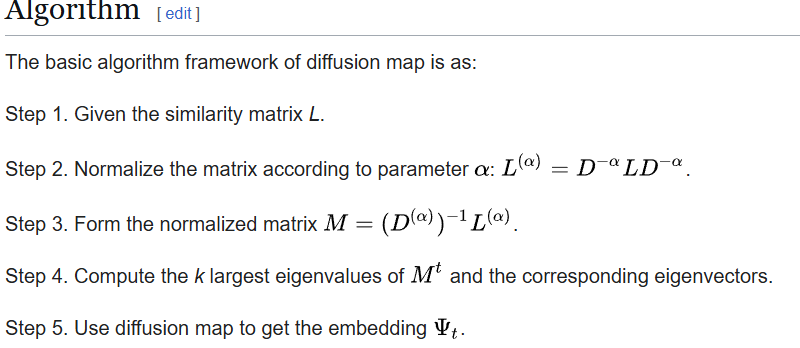

### Note that in step 2 I have used the value of alpha = 1, as this gives the best scores

## Understanding Diffusion maps
This dimensionality reduction technique uses markov chains and random walks to 
estimate the probability of reaching from point i to j in t steps. This consists the diffusion process

Consider n datapoints, we can create a transition matrix P where $P_{ij}$ denotes the probability of sum of all paths going from point $x_i$ to $x_j$
in the dataset X.

This transition probability can be given by the Diffusion kernel, where d(xi, xj) is the DTW distance in case of time series data.

$K_{ij} = \exp \left(-\frac{d(x_i, x_j)^2}{\varepsilon} \right)$



Using the **Perron-Frobenius Theorem**:
Which states that
Any matrix M that is positive (aij > 0), column stochastic matrix ($\sum_{i} a_{ij}$ = 1 ∀j)

Hence, We can say that the matrix P gives 1 as the largest eigen value and all other eigen values are <1.


Another thing is if we take $P^t$ then the elements $P_{ij}$ represent the probability of all paths of length t going from $x_i$ to $x_j$

### Defining Diffusion Distance between $x_i$ and $x_j$

$D_{t}(x_{i}, x_{j})^2$ = $\sum_k(|P_{ik}^t - P_{jk}^t|)^2$

Note, we do not need to calculate P to find the diffusion distance
It can be shown that,



$|Y_{i}-Y_{j}|^2 = D_{t}(x_{i}, x_{j})^2$

where $Y_{i} = (P_{i1}^t, P_{i2}^t, ..., P_{in}^t).T $

$Y_{i}$ is a vector T represents transpose

If we use diffussion distance in the original dataspace as a measure of similarity
then when we project this data in the diffusion/embedding space the similarity is preserved as
noted in the above equation.

Note that we can take the first k elements(excluding the 1st eigen vector) from the vector $Y_{i}$
In the below code I have taken k=3

In [7]:
pairwise_dtw_dissimilarity_matrix_no_bound.ravel().shape

(1000000,)

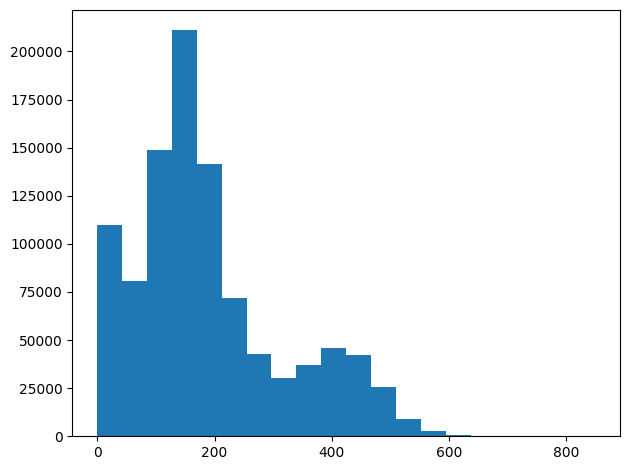

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
N_points = 1000000
n_bins = 20

# Plot histogram for distances to see the distribution
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(pairwise_dtw_dissimilarity_matrix_no_bound.ravel(), bins=n_bins)

plt.show()

In [9]:
sigma_median = np.median(pairwise_dtw_dissimilarity_matrix_no_bound.ravel())
print("Median sigma =", sigma_median)

Median sigma = 158.54597173560018


In [10]:
# kernel matrix
from scipy.linalg import eigh

# similarity_matrix = np.exp(-pairwise_dtw_dissimilarity_matrix) # already squared(see aeon implementation)
similarity_matrix = np.exp(-pairwise_dtw_dissimilarity_matrix_no_bound/sigma_median) # already squared(see aeon implementation)

# dividing by sigma median to normalize the kernel matrix, improves the clustering 
# significantly. This is because if dtw_distance was very big then the similarity
# would be very small and vice versa. So, normalizing it makes the similarity
# matrix more consistent.

D = np.diag(similarity_matrix.sum(axis = 1))   # symmetric dose not matter row or column

# P = similarity_matrix/D[:, None]    # markov transition matrix has probablity of going from i to j
# Can parallelize this step using matrix multiplication
P = np.linalg.inv(D) @ similarity_matrix

# symm_P = (P + P.T)/2

eigenvalues, eigenvectors = np.linalg.eig(P) 

idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

def compute_diffusion_coords(eigenvectors, eigenvalues, n_components, time=1):
    # Considering random walk with 1 step(focuses on local structure    )
    # Increasing t means diffusion will happen with t steps
    # this smoothens the data and focuses on global structure
    # return eigenvectors @ np.diag(np.exp(-time * eigenvalues))[:, 1:n_components+1]
    # print(eigenvectors.shape, eigenvalues.shape)
    # print(eigenvectors[:, 1:n_components+1].shape, eigenvalues[1:n_components+1].shape)
    # print((eigenvectors[:, 1:n_components+1] * eigenvalues[1:n_components+1]).shape)
    return eigenvectors[:, 1:n_components+1] * (eigenvalues[1:n_components+1]**time)

In [11]:
# without dividing by sigma median
# clustering dosent correspond well with the ground truth labels even though the cluster formed
# are very distinct. This is because the similarity matrix is not normalized and hence the
# kernel matrix is not consistent. This is why the clustering is not good.

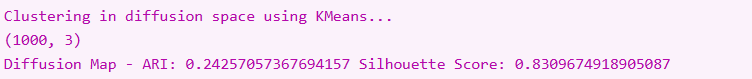

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.linalg import eigh
def clustering_and_evaluation(embedding, true_labels, method='kmeans'):

    if method == 'kmeans':
        k = len(np.unique(true_labels))
        clustering_model = KMeans(n_clusters=k, random_state=42)
    elif method == 'dbscan':
        clustering_model = DBSCAN(eps=0.5, min_samples=5)
    else:
        raise ValueError("Unsupported clustering method")
    print(embedding.shape)
    cluster_labels = clustering_model.fit_predict(embedding)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    sil_score = silhouette_score(embedding, cluster_labels)
    return cluster_labels, ari, sil_score

In [13]:
def flatten_data(X):
    return X.reshape(X.shape[0], -1)

def compute_pca(X, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

def compute_tsne(X, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    return tsne.fit_transform(X)

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}


def plot_embedding(embedding, labels, title):
    plt.figure(figsize=(8,6))

    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  

    for i, label in enumerate(unique_labels):
        idx = labels == label 
        plt.scatter(embedding[idx, 0], embedding[idx, 1], 
                    label=activity_labels[label], c=[colors[i]], alpha=0.5, edgecolors='k')

    # plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.legend(title="Activities", loc="best", fontsize=10)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar()
    plt.show()

## Clustering in the Diffusion Space

### time = 1 seems to be the best choice

In [14]:
print(np.real(eigenvalues))

[ 1.00000000e+00  5.10709410e-01  1.59185685e-01  7.01208713e-02
  5.86290417e-02  5.44986297e-02  4.85806574e-02  3.92711208e-02
  3.77986230e-02  3.31930978e-02  2.97729220e-02  2.57865631e-02
  2.27786946e-02  2.13976380e-02  1.90922118e-02  1.75663302e-02
  1.66536350e-02  1.40842131e-02  1.35790227e-02  1.19211167e-02
  1.16086840e-02  1.11562920e-02  1.08600206e-02  9.72385095e-03
  9.51495420e-03  9.43363561e-03  8.56912266e-03  8.20538175e-03
  8.14241637e-03  7.82629928e-03  7.64774099e-03  7.38961193e-03
  7.06504236e-03  6.98073327e-03  6.77123661e-03  6.40790351e-03
  6.24379808e-03  6.03694588e-03  5.94112224e-03  5.86769252e-03
  5.66030996e-03  5.56448903e-03  5.40347299e-03  5.31873642e-03
  5.21414961e-03  5.05759181e-03  4.95343007e-03  4.81630911e-03
  4.72782975e-03  4.64147118e-03  4.51920316e-03  4.48258315e-03
  4.42358214e-03  4.26102615e-03  4.16472700e-03  4.12950765e-03
  3.96247482e-03  3.86259312e-03  3.82837976e-03  3.76211123e-03
  3.73260031e-03  3.66807

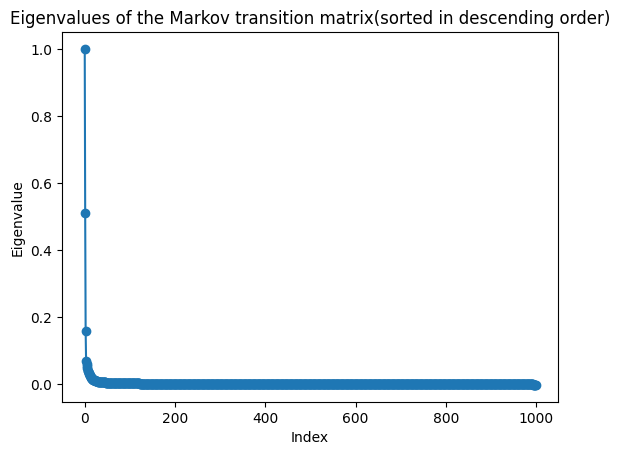

In [15]:
plt.plot(np.real(eigenvalues), 'o-')
plt.title("Eigenvalues of the Markov transition matrix(sorted in descending order)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()

In [16]:
# We pass the eigenvectors and eigenvalues to the function to compute the diffusion coordinates
# The function returns the diffusion coordinates, by ignoring the first eigenvalue and eigenvector
# The first eigenvalue and eigenvector are ignored because they correspond to the trivial solution

diffusion_coords = np.real(compute_diffusion_coords(eigenvectors, eigenvalues, n_components=3 , time=1))
print("Clustering in diffusion space using KMeans...")
cluster_labels_diff, ari_diff, sil_diff = clustering_and_evaluation(diffusion_coords, y_train[:1000], method='kmeans')
print("Diffusion Map - ARI:", ari_diff, "Silhouette Score:", sil_diff)

Clustering in diffusion space using KMeans...
(1000, 3)
Diffusion Map - ARI: 0.4782825147753031 Silhouette Score: 0.6138027690504942


In [17]:
diffusion_coords_temp = np.real(compute_diffusion_coords(eigenvectors, eigenvalues, n_components=3 , time=8))
print("Clustering in diffusion space using KMeans...")
cluster_labels_diff, ari_diff, sil_diff = clustering_and_evaluation(diffusion_coords_temp, y_train[:1000], method='kmeans')
print("Diffusion Map - ARI:", ari_diff, "Silhouette Score:", sil_diff)

Clustering in diffusion space using KMeans...
(1000, 3)
Diffusion Map - ARI: 0.25297020131276876 Silhouette Score: 0.686669312351343


In [18]:
diffusion_coords_temp = np.real(compute_diffusion_coords(eigenvectors, eigenvalues, n_components=3 , time=50))
print("Clustering in diffusion space using KMeans...")
cluster_labels_diff, ari_diff, sil_diff = clustering_and_evaluation(diffusion_coords_temp, y_train[:1000], method='kmeans')
print("Diffusion Map - ARI:", ari_diff, "Silhouette Score:", sil_diff)

Clustering in diffusion space using KMeans...
(1000, 3)
Diffusion Map - ARI: 0.25297020131276876 Silhouette Score: 0.686669476517941


## Visualization and Interpretation

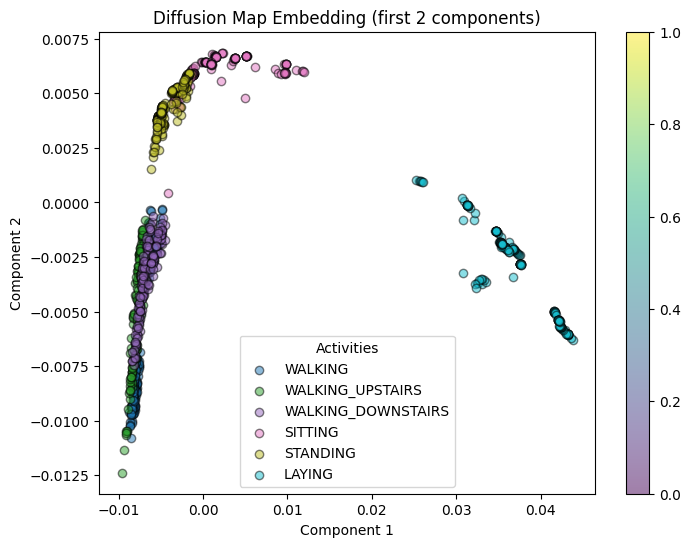

In [19]:
# Plot the diffusion map embedding (using the first two diffusion coordinates)
plot_embedding(diffusion_coords[:, :2], y_train[:1000], "Diffusion Map Embedding (first 2 components)")


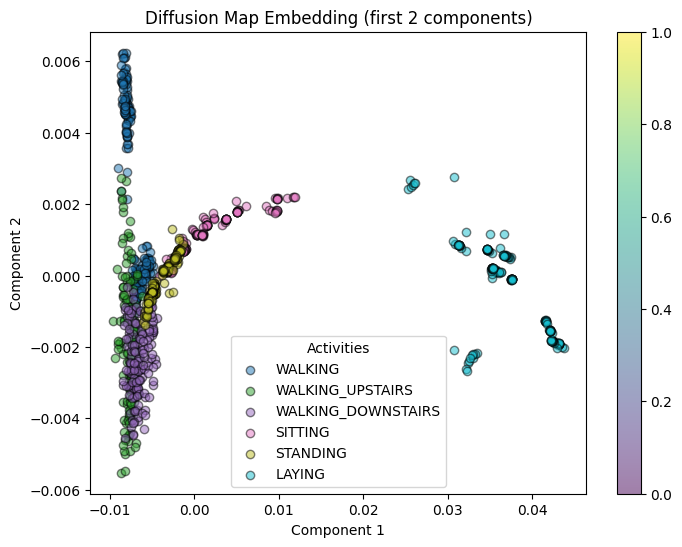

In [20]:
plot_embedding(diffusion_coords[:, [0, 2]], y_train[:1000], "Diffusion Map Embedding (first 2 components)")

In [21]:
X_flat = flatten_data(X_train[:1000])
print("Clustering in raw feature space...")
cluster_labels_raw, ari_raw, sil_raw = clustering_and_evaluation(X_flat, y_train[:1000], method='kmeans')
print("Raw Feature Space - ARI:", ari_raw, "Silhouette Score:", sil_raw)

Clustering in raw feature space...
(1000, 1152)
Raw Feature Space - ARI: 0.2968409437567964 Silhouette Score: 0.13039108175504283


In [22]:
# PCA embedding
pca_coords = compute_pca(X_flat, n_components=3)
print("Clustering in PCA space...")
cluster_labels_pca, ari_pca, sil_pca = clustering_and_evaluation(pca_coords, y_train[:1000], method='kmeans')
print("PCA - ARI:", ari_pca, "Silhouette Score:", sil_pca)

Clustering in PCA space...
(1000, 3)
PCA - ARI: 0.39081158060003784 Silhouette Score: 0.45552093767594737


In [23]:
# t-SNE embedding
tsne_coords = compute_tsne(X_flat, n_components=3)
print("Clustering in t-SNE space...")
cluster_labels_tsne, ari_tsne, sil_tsne = clustering_and_evaluation(tsne_coords, y_train[:1000], method='kmeans')
print("t-SNE - ARI:", ari_tsne, "Silhouette Score:", sil_tsne)

Clustering in t-SNE space...
(1000, 3)
t-SNE - ARI: 0.25734057971635116 Silhouette Score: 0.30087483


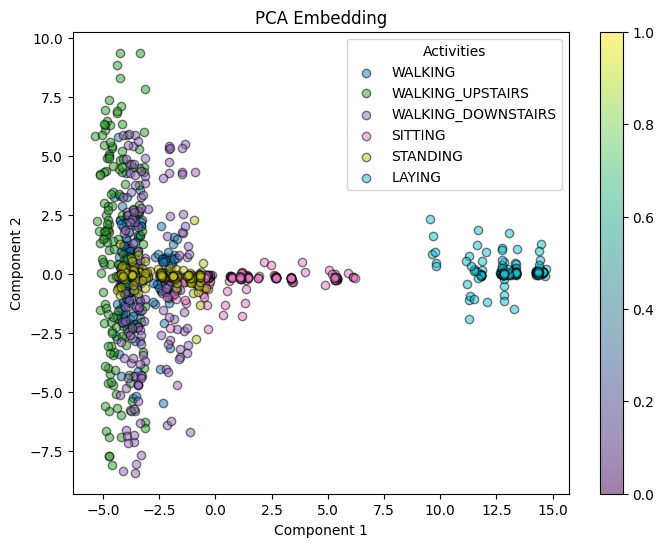

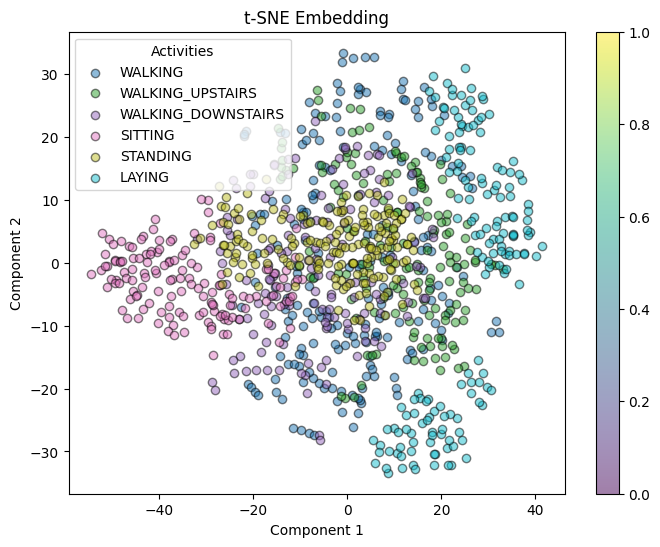

In [24]:
# Plot the alternative embeddings
plot_embedding(pca_coords[:, :2], y_train[:1000], "PCA Embedding")
plot_embedding(tsne_coords, y_train[:1000], "t-SNE Embedding")

## Observations

### Adjusted Rand Index (ARI):
ARI measures how well the clustering results match the known ground truth labels. Here, diffusion maps (ARI ≈ 0.47) outperforms the other methods, meaning that clusters obtained in the diffusion space align best with the activity labels. 

PCA (ARI ≈ **0.39**)
Raw feature space (ARI ≈ **0.297**)
t-SNE (ARI ≈ **0.257**) 

This suggests that, in terms of matching the provided labels, diffusion maps produces clusters that most closely reflect the expected classes.

### Silhouette Score:
The silhouette score reflects the quality of the clustering, how **well-separated and compact the clusters** are.

Diffusion maps dominate in this respect with a high silhouette score of **0.688**, indicating that within the diffusion space, the clusters are very well-defined and separated. 

PCA also shows good separation  **0.456**, followed by t-SNE **0.300**, and raw features shows **0.130**.

## Conclusion: Why diffusion maps perform well for timeseries data

### Capturing Non Linear Manifolds
Diffusion maps work by constructing a Markov process over the data points, where the transition probabilities reflect local similarities. This process uncovers the complex nonlinearity of the underlying data manifold(manifold learning). 

For time-series data, which often lie on complex, nonlinear manifolds, this means that the essential complex structures(such as temporal correlations) are preserved in the lower-dimensional space after the embedding.

### Comparison with Other Techniques
**PCA**: PCA is a linear dimensionality reduction technique, due to this it can fail to capture the complex, nonlinear structures in the data, for timeseries data with multiple dimensions this is often the case. 
The slightly lower ARI (≈ 0.39) and silhouette score (≈ 0.456) suggest that PCA does not separate the classes as effectively.

**t-SNE**: t-SNE is good at preserving local structure but can sometimes distort the global relationships between clusters. Its lower ARI (≈ 0.257) and silhouette score (≈ 0.300) imply that while it can reveal local groupings, it might not be as effective at maintaining the overall cluster structure in the context of time-series.

**Raw Feature Space**: Clustering in the raw feature space (ARI ≈ 0.297 and silhouette ≈ 0.130) tends to suffer due to high dimensionality and noise, making it harder to uncover the inherent temporal patterns without any form of transformation or reduction.

TODO: # Add legend/labels in the plots

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

def plot_embedding_3d(embedding, labels, title):
    """
    Plots a 3D scatter plot of the given embedding.
    
    Parameters:
        embedding (ndarray): Array of shape (n_samples, 3) representing the 3D embedding.
        labels (ndarray): Array of labels corresponding to each sample.
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        idx = labels == label
        ax.scatter(embedding[idx, 0], embedding[idx, 1], embedding[idx, 2],
                   label=activity_labels[label], color=colors[i], alpha=0.5, edgecolor='k')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    ax.set_zlabel('Component 3', fontsize=12)
    ax.legend(title="Activities", loc="best", fontsize=10)
    plt.show()

# Example usage:
# Assuming embedding is an (n, 3) array, labels is an (n,) array, and activity_labels is a dict mapping label codes to names.
# plot_embedding_3d(embedding, labels, "3D Embedding of Activity Data")


## Explorative

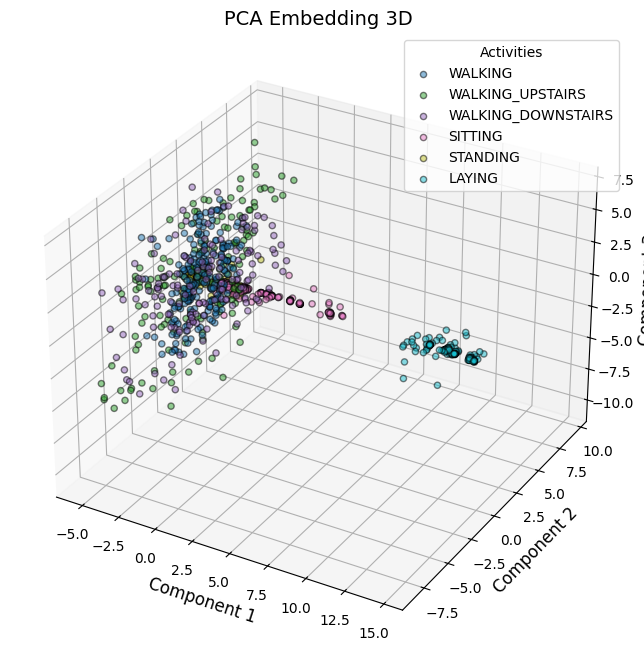

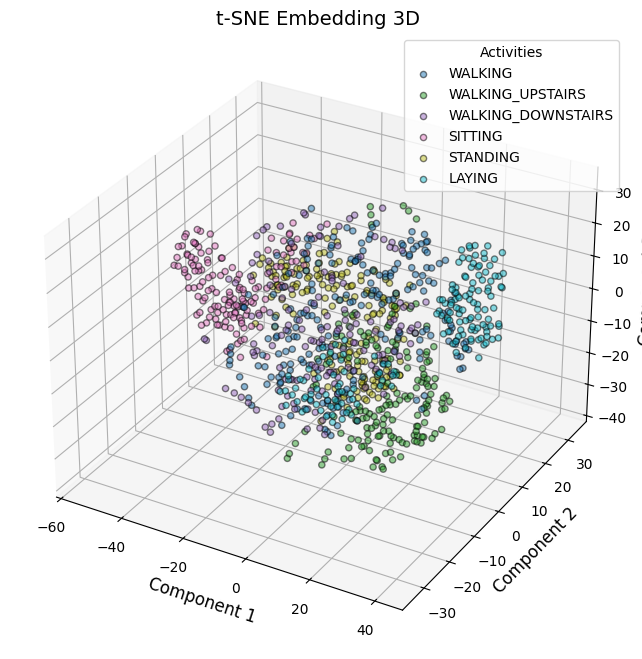

In [29]:
# Plot the alternative embeddings
plot_embedding_3d(pca_coords, y_train[:1000], "PCA Embedding 3D")
plot_embedding_3d(tsne_coords, y_train[:1000], "t-SNE Embedding 3D")

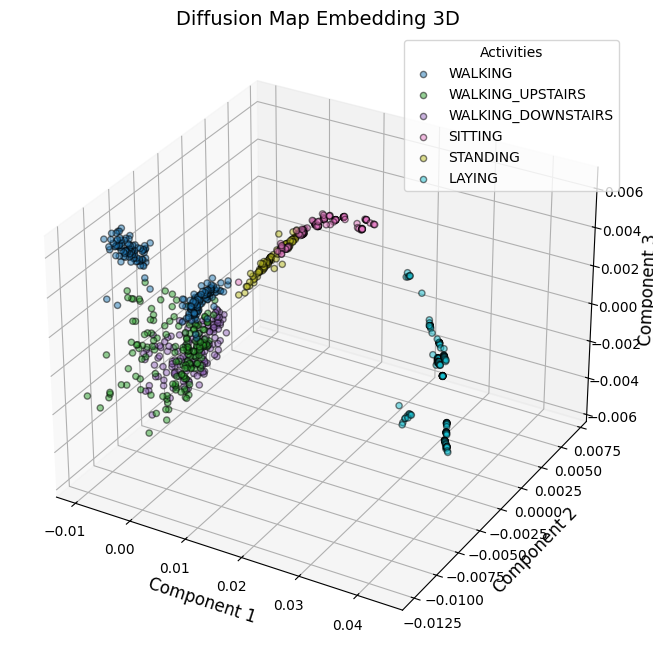

In [30]:
plot_embedding_3d(diffusion_coords, y_train[:1000], "Diffusion Map Embedding 3D")
